## Setup

NOTE: This is the main file of the BPNN pipeline. All dependencies are within a conda environment to ensure reproducibility. To install all dependencies: pip install -r requirements.txt


### Step 1: Make sure Tensorflow finds the GPU

In [1]:
import tensorflow.compat.v1 as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-06-15 16:46:10.356357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:46:10.393776: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


2023-06-15 16:46:11.231095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 16:46:11.244482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 16:46:11.244592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# #Lets see if it works
tf.ones(1) + tf.ones(1)

2023-06-15 16:46:11.247831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:46:11.248422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 16:46:11.248530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-15 16:46:11.248599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative val

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

### Step 2: Import all libraries and packages

In [38]:
# Main packages
import numpy as np # for working with arrays and matrices
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization


# # Secondary packages
import time # for time-related functions
import random # for random number generation
# import cv2 # for computer vision and image processing tasks
# import datetime # for saving date and time information
# import csv # for loading csv files
# import h5py # for working with HDF5 (Hierarchical Data Format) files
# import boto3 # for working with Amazon Web Services (AWS)
# from pynwb import NWBHDF5IO # for working with Neurodata Without Border (NWB) files
# import fsspec # "File System Specifications" and is a Python library that provides a unified interface for accessing various file systems and storage backends.
# from fsspec.implementations.cached import CachingFileSystem # library used for working with various file systems in Python.
# import requests #  simplifies making HTTP requests.
# import aiohttp # libraries which are used for making HTTP requests in Python.
import os # OS module provides various operating system-related functions to the code
# import pickle # allows you to convert Python objects into a binary representation (serialization) that can be stored or transmitted, and later restore (deserialization) those objects back into Python.
# import re # The re module is a standard library in Python that provides support for regular expressions, which are powerful tools for pattern matching and manipulation of strings.


# # ML/DL-related packages
# used for splitting data into training and testing sets in Python.
from sklearn.model_selection import train_test_split 
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.utils import plot_model
# import imgaug.augmenters as iaa
# from sklearn.model_selection import KFold


# import importlib


# # Loading functions
from load_calcium_video import load_video_data, load_one_video
# from pixel_values_normalization import normalize_video
from align_behavior_to_calcium import align_files_old_labels, align_files_new_labels
from class_balance import check_class_imbalance_old, check_class_imbalance_new, check_class_imbalance_old_merged
# from model_architecture import construct_model
from preprocessing_model import model_preprocessing
# from run_model import model_execution
# from save_model_info import save_training_info
from plots import plot_first_frames, plot_random_frames, plot_image_pixel_values
from run_BPNN import run
# import run_k_fold_model
# import keras_tuner
# from urllib.parse import urlparse
# from ann_visualizer.visualize import ann_viz
# import sys
# # sys.path.append('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3')
# from nwb_data_generator import NWBDataGeneratorTime

### Step 3: Set and store experiment details

In [4]:
# What will you be executing today?
comment =  "Test"

# Give this experiment an ID number
experiment_ID = 'BPNN_V4.2'

# Which animal data files are you using?
data_file = 'Animal3Learnday11'

# What is the experiment's name?
experiment_name = str(data_file)+"_"+str(experiment_ID)

# What is the train-test split strategy?
train_test_split_strategy = "k-fold"

# What is the version of the BPNN model?
name = 'BPNN_V4'

# What is the BPNN's version?
# model_version = str(name)+'_1'

# Which labels are you using? Old or New?
labels_type_new = True # 'old'

# Will you merge labels or not?
merge_labels = False

# Would you like to shuffle the labels?
# shuffle = True

# Are you analysing multiple videos or only one?
multiple_videos = False 

In [5]:
# store the experiment variables:
%store experiment_ID
%store data_file
%store experiment_name
# %store train_test_split_strategy
%store name
# %store model_version
%store labels_type_new
%store merge_labels
%store multiple_videos
# %store shuffle

Stored 'experiment_ID' (str)
Stored 'data_file' (str)
Stored 'experiment_name' (str)
Stored 'name' (str)
Stored 'labels_type_new' (bool)
Stored 'merge_labels' (bool)
Stored 'multiple_videos' (bool)


### Step 4: Create a directory for the output files (update)

In [6]:
output_dir = str(experiment_ID)+'_output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    os.mkdir(os.path.join(output_dir, "balance"))
    # os.mkdir(os.path.join(output_dir, "accuracy"))
    # os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
    # os.mkdir(os.path.join(output_dir, "results"))
    
%store output_dir

Stored 'output_dir' (str)


### Step 5: Load the Calcium Videos that will be analysed (update)

In [7]:
video_name_list = []
video_data_list = []

if multiple_videos == True:
    
    # paths to videos
    video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]
    
    # load the CSV file with the FOV information
    fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')
    images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

    
else:
    # change the path if you're using another video other than animal3learnday11
    # video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_174510_animal2learnday11.nwb"]    
    video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.nwb"]
    images = load_one_video(video_path, video_name_list)

20211028_181307_animal3learnday11.nwb recording_20211028_181307-PP-BP-MC
(24589, 393, 444)


In [8]:
# Check if the video has been loaded correctly. It should be an array of pixel values
images[:1]

array([[[175, 181, 182, ..., 181, 181, 180],
        [170, 174, 173, ..., 177, 176, 179],
        [175, 175, 168, ..., 180, 176, 178],
        ...,
        [180, 182, 175, ..., 170, 173, 167],
        [177, 188, 181, ..., 177, 179, 180],
        [184, 184, 183, ..., 188, 182, 174]]], dtype=int16)

In [9]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of frames in the calcium imaging video is ", num_of_frames, "and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of frames in the calcium imaging video is  24589 and the frame dimensions (height x width) are:  393 X 444


### Step 6: Load Behaviour Labels

In [10]:
# set this depending on how many videos you're reading
num_of_videos = 1


if multiple_videos == False:
    
    # bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T17_45_15.csv"]
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T18_13_23.csv"]
    if labels_type_new == False:
        
        # behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_174510_animal2learnday11.h5"]
        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.h5"]
        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos, merge_labels)
    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path, multiple_videos)


else:
    
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
                    "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
                    "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]
    
    if labels_type_new == False:
        
        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
                          "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
                          "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]
        
        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos, merge_labels)
    
    else:
        
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path, multiple_videos)

In [11]:
df_new_annotations_check #df_new_annotations_check

,state_id,state_name
0,0,grooming
1,0,grooming
2,0,grooming
3,0,grooming
4,0,grooming
...,...,...
24584,3,moving
24585,3,moving
24586,3,moving
24587,3,moving


In [12]:
reordered_annotations = df_new_annotations_check.drop_duplicates()
reordered_annotations = reordered_annotations.sort_values('state_id')
reordered_annotations = reordered_annotations.reset_index(drop=True)

In [13]:
reordered_annotations.at[0, 'state_name'] = 'Grooming'
reordered_annotations.at[1, 'state_name'] = 'Frozen'
reordered_annotations.at[2, 'state_name'] = 'Not moving'
reordered_annotations.at[3, 'state_name'] = 'Moving'
reordered_annotations.at[4, 'state_name'] = 'Right turn'
reordered_annotations.at[5, 'state_name'] = 'Left turn'

In [14]:
reordered_annotations

,state_id,state_name
0,0,Grooming
1,1,Frozen
2,2,Not moving
3,3,Moving
4,4,Right turn
5,5,Left turn


In [15]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

### Step 7: Aligning Behavior with Calcium video

In [16]:
df_new_annotations = df_new_annotations.reset_index(drop=True)
df_new_annotations_unique = reordered_annotations['state_id'].unique()

In [17]:
df_new_annotations_unique

array([0, 1, 2, 3, 4, 5], dtype=object)

In [18]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

In [19]:
df_new_annotations_check

,state_id,state_name
0,0,grooming
1,0,grooming
2,0,grooming
3,0,grooming
4,0,grooming
...,...,...
24584,3,moving
24585,3,moving
24586,3,moving
24587,3,moving


In [20]:
# labels_number = len()'all' # can be also 3 (merged) or 6 (new)

In [21]:
no_of_labels = len(reordered_annotations)
%store no_of_labels

Stored 'no_of_labels' (int)


In [22]:
no_of_labels

6

### Step 8: Check the balance of the behaviour labels

In [23]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/"+str(output_dir)+"/balance"

In [24]:
# check balance
total_counts = 0
for i in range(len(df_new_annotations_unique)):
    class_counts = pd.value_counts(df_new_annotations_check['state_id'])
    total_counts = total_counts + class_counts[i]
# calculate the percentage of each class in the dataset
class_percents = pd.value_counts(df_new_annotations, normalize=True) * 100
print(class_percents,"\n",class_counts)

1    33.596324
3    24.868844
0    17.276018
2    15.641140
5     4.347472
4     4.270202
Name: state_id, dtype: float64 
 1    8261
3    6115
0    4248
2    3846
5    1069
4    1050
Name: state_id, dtype: int64


In [25]:
label_names = reordered_annotations['state_name']

In [26]:
label_names

0      Grooming
1        Frozen
2    Not moving
3        Moving
4    Right turn
5     Left turn
Name: state_name, dtype: object

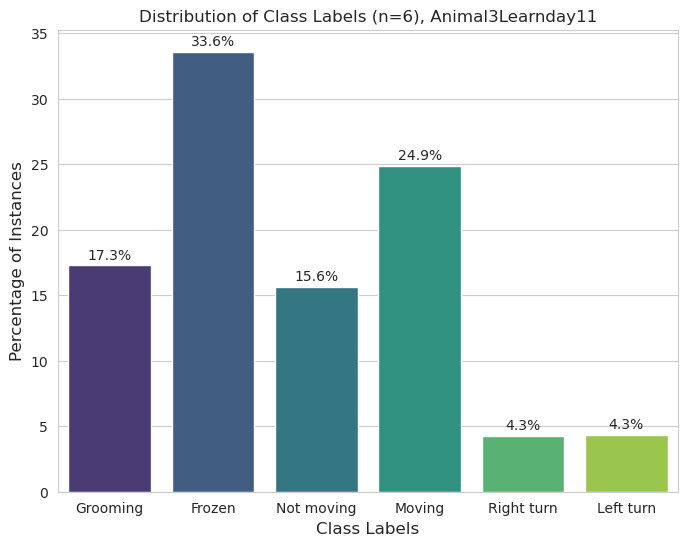

In [27]:
if labels_type_new == True:
    class_counts, total_counts = check_class_imbalance_new(df_new_annotations, 
                                                           experiment_ID, 
                                                           save_dir, 
                                                           df_new_annotations_unique, 
                                                           df_new_annotations_check, 
                                                           no_of_labels, 
                                                           data_file,
                                                           label_names)

elif merge_labels == True:
    names_of_labels = 'Main Corr', 'Left Corr', 'Right Corr'
    class_counts, total_counts = check_class_imbalance_old_merged(df_new_annotations, 
                                                                  experiment_ID, 
                                                                  save_dir, 
                                                                  df_new_annotations_unique, 
                                                                  df_new_annotations_check, 
                                                                  no_of_labels, 
                                                                  names_of_labels, 
                                                                  data_file,
                                                                  label_names)

else:
    class_counts, total_counts = check_class_imbalance_old(df_new_annotations, 
                                                           experiment_ID, 
                                                           save_dir, 
                                                           df_new_annotations_unique, 
                                                           df_new_annotations_check, 
                                                           no_of_labels, 
                                                           data_file,
                                                           label_names)

### Step 9: Data Verification

In [28]:
# Check that the Images and Labels have the same length
labels = df_new_annotations
if len(labels) == len(images):
    print("Labels and Images have the same length:", len(images))

Labels and Images have the same length: 24589


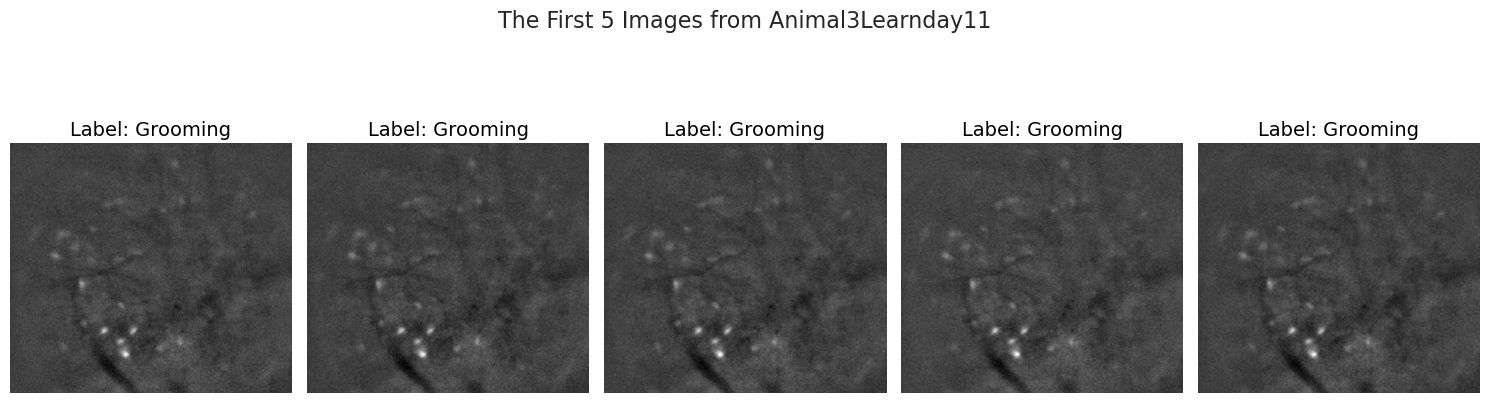

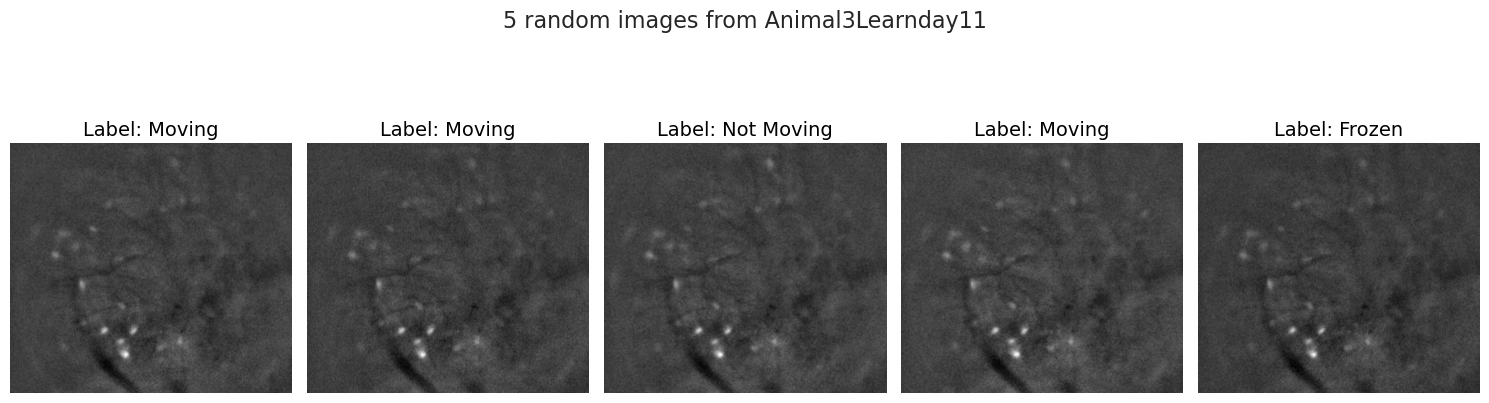

In [29]:
plot_first_frames(images, labels, data_file)
plot_random_frames(images, labels, data_file)

### Step 10: Create the input shape of the data before model training

In [30]:
num_classes = len(label_names)

In [31]:
images, labels = model_preprocessing(images, 
                                     labels, 
                                     df_new_annotations_unique,
                                     num_classes)

### Step 11: Training the BPNN

#### Set the Training Parameters

In [32]:
# model type
is_basic_BPNN = False # True means WITHOUT time dimension. False means WITH time dimension

if is_basic_BPNN == True:
    channel_dimension = 1
else:
    channel_dimension = 7 #3 or 5 if you're including the time dimension

input_shape = (img_height, 
               img_width, 
               channel_dimension)

# set number of folds
num_folds = 2 # 10

# number of epochs
epochs = 1

# define if shuffle data
shuffle = False

# names of unique behaviours
df_new_annotations_names = label_names.unique()

# number of unique behaviour labels
no_of_behaviors = len(label_names)

#### Run Model

Running Animal3Learnday11 on the BPNNt, with 5-Fold CV, 1 Epochs, and Early Stopping



Fold 1/2



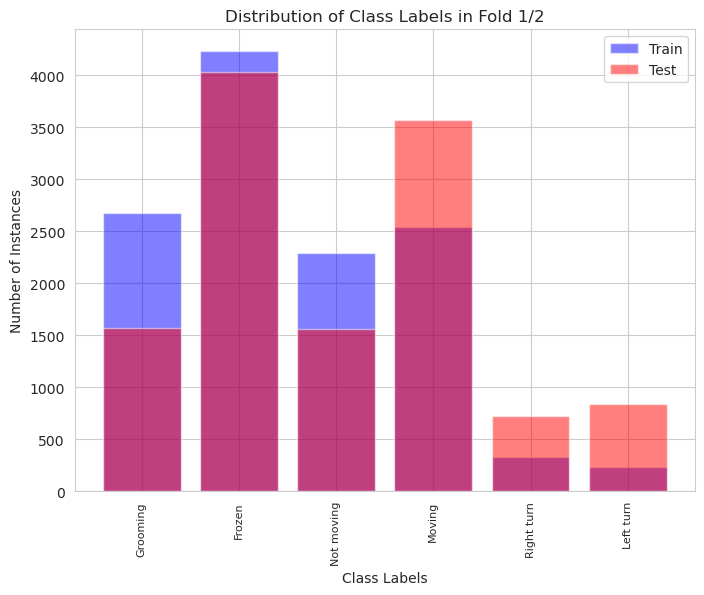

Splitting data with NWBDataGenerator

Length of training and validation sets: 12294 12295
Creating Model

Compiling model...

Done :) 

Training model. Go grab a coffee or take a walk.


2023-06-15 16:46:25.858916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-06-15 16:46:26.830107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


384/384 [==============================] - 94s 237ms/step - loss: 1.5703 - accuracy: 0.3308 - val_loss: 1.7540 - val_accuracy: 0.3011

Evaluating model...
Validation loss: 1.7540
Validation accuracy: 0.3011

Generating predictions on validation data
384/384 [==============================] - 45s 118ms/step
F1 score is: 0.301



Fold 2/2



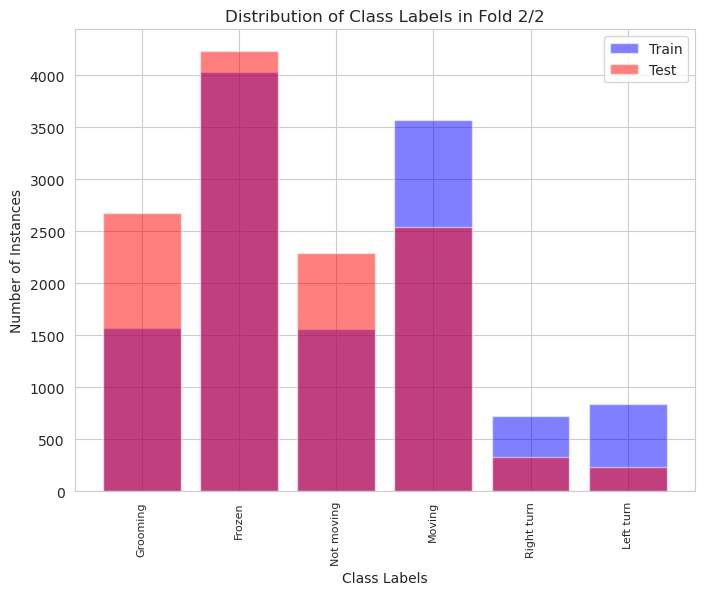

Splitting data with NWBDataGenerator

Length of training and validation sets: 12295 12294
Creating Model

Compiling model...

Done :) 

Training model. Go grab a coffee or take a walk.
384/384 [==============================] - 91s 237ms/step - loss: 1.7426 - accuracy: 0.3252 - val_loss: 1.5632 - val_accuracy: 0.3514

Evaluating model...
Validation loss: 1.5632
Validation accuracy: 0.3514

Generating predictions on validation data
384/384 [==============================] - 45s 118ms/step
F1 score is: 0.351

Done!

Plotting confusion matrix

Plotting the confusion matrix for fold 0


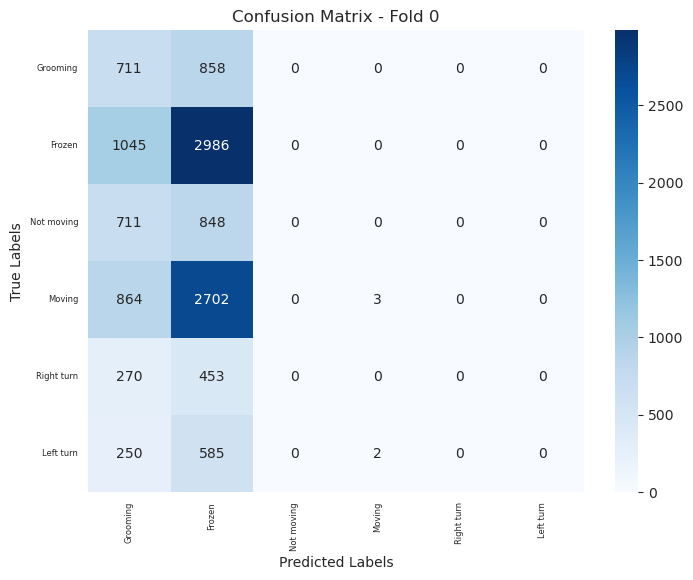

Plotting the confusion matrix for fold 1


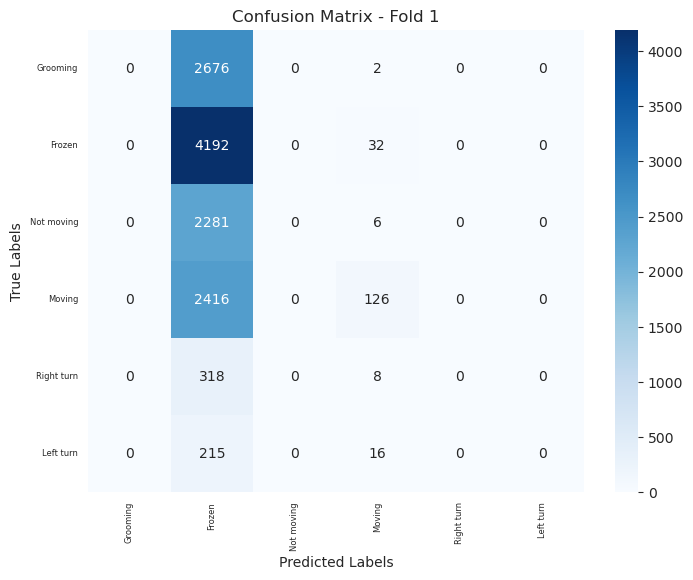

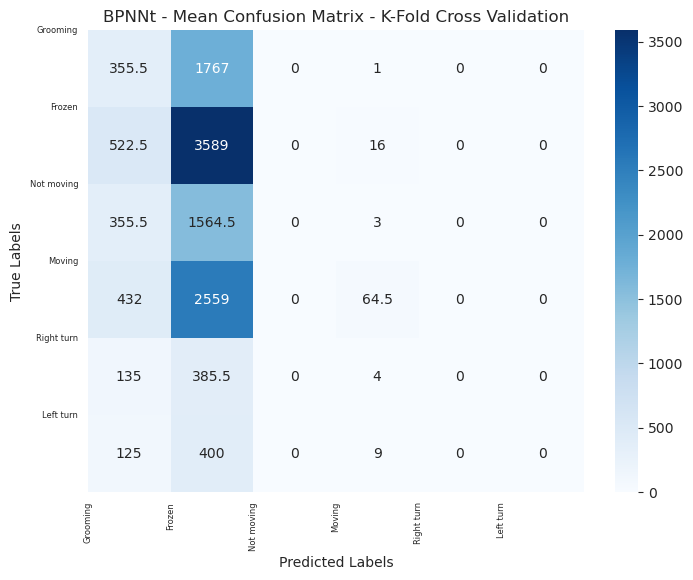

In [33]:
if is_basic_BPNN == True:
    print("Running "+data_file_file+" on the BPNN, with 5-Fold CV, "+epochs+" Epochs, and Early Stopping")
    train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices, f1_score_val_list, train_labels_names = run(is_basic_BPNN,
        label_names,
        labels_type_new, 
        shuffle,
        images,
        labels,
        num_folds,
        #shuffled_labels,
        input_shape,
        num_classes,
        name,
        epochs,
        no_of_behaviors,
        df_new_annotations,
        df_new_annotations_unique,
        df_new_annotations_check,
        output_dir,
        experiment_ID)
else:
    print("Running "+str(data_file)+" on the BPNNt, with 5-Fold CV, "+str(epochs)+" Epochs, and Early Stopping")
    train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices, f1_score_val_list, train_labels_names = run(is_basic_BPNN,
        label_names,
        labels_type_new, 
        shuffle,
        images,
        labels,
        num_folds,
        #shuffled_labels,
        input_shape,
        num_classes,
        name,
        epochs,
        no_of_behaviors,
        df_new_annotations,
        df_new_annotations_unique,
        df_new_annotations_check,
        output_dir,
        experiment_ID)

### Step 12: Saving Results

In [34]:
train_labels_names
%store train_labels_names

Stored 'train_labels_names' (Series)


In [35]:
f1_score_mean = np.mean(f1_score_val_list)

In [36]:
f1_score_mean

0.3262532552083333

In [39]:
# plot the f1 score per fold to see how the performance falls with time. 


labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Choose a color palette from seaborn's built-in palettes
color_palette = 'Set2'


sns.barplot(x=labels, y=f1_score_val_list, palette=color_palette)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Fold')

# Specify the folder path where you want to save the plot
save_folder = '/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3'

# Save the plot in the specified folderf1
plt.savefig(save_folder + 'f1_scores_per_fold.svg', dpi=300, bbox_inches='tight')

plt.show()

KeyError: 'Fold 1'

In [ ]:
f1_score_val_list

In [ ]:
f1_score_mean

In [ ]:
val_acc_all

In [ ]:
conf_matrices

In [ ]:
#plot the mean confusion matrix
mean_cm = np.mean(conf_matrices, axis=0)
# train_labels_names = ['moving', 'rightTurn', 'immobile', 'grooming', 'still', 'leftTurn']
plt.figure(figsize=(8, 6))
sns.heatmap(mean_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Mean Confusion Matrix - K-Fold Cross Validation')
plt.xlabel('Predicted Labels')
plt.xticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, rotation=90, fontsize=6)
plt.ylabel('True Labels')
plt.yticks(np.arange(len(train_labels_names)) + 0.5, train_labels_names, rotation=0, fontsize=6)
plt.savefig("mean_CM"+str(experiment_ID)+'.svg', bbox_inches='tight', dpi=300)
plt.show()

%store conf_matrices
%store train_labels_names

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/"+str(output_dir)

In [ ]:
%store train_loss_all
%store val_loss_all
%store train_acc_all
%store val_acc_all
%store f1_score_val_list
%store f1_score_mean
%store epochs
%store total_accuracy_score
%store num_folds
%store conf_matrices
%store num_folds
%store no_of_labels

In [ ]:
# %store model
# %store history
%store name
%store comment
%store save_dir

### Snippets for running the model without 5-fold CV

In [ ]:
# # Split the data into training and validation sets
split_index = int(0.2 * len(images))  # Index to split data

# images = np.concatenate([images, images, images], axis=-1)

val_images, train_images = images[:split_index], images[split_index:]
val_labels, train_labels = labels[:split_index], labels[split_index:]

In [ ]:
train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)

In [ ]:
# # Plot the first 5 random images
plot_first_frames(train_images, train_labels, vmin, vmax)
plot_first_frames(val_images, val_labels, vmin, vmax)

### Reflect on the results

High bias: If the training accuracy is low, it suggests that the model is underfitting the training data, i.e., it is not complex enough to capture the patterns in the data. In this case, you may need to increase the model's complexity by adding more layers or neurons, or by using a more complex architecture.

High variance: If the training accuracy is high but the validation accuracy is low, it suggests that the model is overfitting the training data, i.e., it is memorizing the training data instead of generalizing to new data. In this case, you may need to use regularization techniques like dropout or L2 regularization, or use early stopping to prevent the model from overfitting.

Good fit: If the training accuracy and validation accuracy are both high and close to each other, it suggests that the model is neither underfitting nor overfitting the data, i.e., it is generalizing well to new data.

Plateauing: If the validation accuracy is no longer increasing as the training set size or epochs increase, it suggests that the model has reached its capacity and adding more data or epochs is unlikely to improve its performance.

In general, a model accuracy curve can help you diagnose issues with your model and guide you in selecting appropriate strategies to improve its performance. It can also give you an idea of how much training data or how many epochs you need to achieve good performance.

1. Insufficient data? One calcium video of 24186 frames and with 349x374 dimensions.
2. Model architecture not appropriate. Try increasing the number of layers or filters, or adding more complex layers like BatchNormalization, Dropout, or Conv2DTranspose.
3. Incorrect data preprocessing
4. Incorrect hyperparameters
5. Class Imbalance (do oversampling, or undersampling)

### Reusable snippets

In [ ]:
# Load calcium video from local environment
# with h5py.File('path', 'r') as f:
#     video_data = np.array(f['analysis/recording_20211016_163921-PP-BP-MC/data'])

In [ ]:
# Loading locally
# with h5py.File('/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.h5', 'r') as f:
#     print(list(f.keys()))
#     behavior_data = np.array(f['per_frame'])

In [ ]:
# # save the model architecture to a JSON file
# with open('model_architecture.json', 'w') as f:
#     f.write(model.to_json())

In [ ]:
# # load the model architecture from the JSON file
# with open('model_architecture.json', 'r') as f:
#     json_string = f.read()

# model_json = model_from_json(json_string)

# # print the loaded model summary
# model.summary()

### Other

Helpful source: https://keras.io/examples/vision/video_classification/

The number of frames may differ from video to video.
The frame rate may also differ from video to video but it should be 20fps for all. 

The duration of each frame depends on the frame rate of the video. If a video has a frame rate of 25 fps, then each frame will have a duration of 1/25th of a second, or approximately 0.04 seconds. The calcium videos use 20fps, while the behavioral recordings are at 60fps. Alignment of these videos will follow shortly. 